# Hackathon MKB 2021

## Задача проекта

Спрогнозировать вероятность невыполнения
контракта поставщиком


## Описание данных

Банковская гарантия — соглашение, по которому банк обязан выплатить долг клиента, если тот не выполнил своих обязательств. Выдача гарантий банком происходит после одобрения клиентской заявки.

Задача — построить аппликационную модель оценки вероятности предъявления по гарантии, чтобы минимизировать потери от кредитного риска. В качестве предикторов для моделирования используются анкетные данные клиента и его финансовые показатели.

Решения оцениваются по метрике **ROC/AUC Score**

## Импорт библиотек

In [1]:
! pip install catboost

In [2]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split

from catboost import CatBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression

##  Подготовка данных

Тут была ячейка со скачиванием данных, но они не из открытых источников, поэтому я ее удалил

In [4]:
train = pd.read_csv('/content/train_dataset_hackathon_mkb.csv', sep=';', encoding='cp1251')
test = pd.read_csv('/content/test_dataset_hackathon_mkb.csv', sep=';', encoding='cp1251')

In [5]:
print('Размер обучающей выборки: {:}'.format(train.shape))
train.head()

Размер обучающей выборки: (17891, 124)


,id_contract,id_client,SIGN_DATE,IP_flag,TARGET,F1100,F1110,F1150,F1160,F1170,F1180,F1190,F1200,F1210,F1220,F1230,F1240,F1250,F1260,F1300,F1310,F1320,F1350,F1360,F1370,F1400,F1410,F1420,F1450,F1500,F1510,F1520,F1530,F1550,F1600,F1700,F2100,F2110,F2120,F2200,...,MANAGERCOUNTINREGION,MANAGERINNCOUNT,OKVED_CODE,PLAINTIFF_CASESNUMBER_YEAR,PLAINTIFF_SUM_YEAR,DEFENDANT_CASESNUMBER_YEAR,DEFENDANT_SUM_YEAR,THIRDOROTHERPERSON_YEAR,PLAINTIFF_CASESNUMBER_EVER,PLAINTIFF_SUM_EVER,DEFENDANT_CASESNUMBER_EVER,DEFENDANT_SUM_EVER,THIRDOROTHERPERSON_EVER,ADMITTEDNUMBER_233_YEAR,NOTADMITTEDNUMBER_233_YEAR,WINNERNUMBER_233_YEAR,SIGNEDNUMBER_233_YEAR,SUM_233_YEAR,ADMITTEDNUMBER_233_EVER,NOTADMITTEDNUMBER_233_EVER,WINNERNUMBER_233_EVER,SIGNEDNUMBER_233_EVER,SUM_233_EVER,ADMITTEDNUMBER_95_YEAR,NOTADMITTEDNUMBER_95_YEAR,WINNERNUMBER_95_YEAR,SIGNEDNUMBER_95_YEAR,SUM_95_YEAR,ADMITTEDNUMBER_95_EVER,NOTADMITTEDNUMBER_EVER,WINNERNUMBER_95_EVER,SIGNEDNUMBER_95_EVER,SUM_95_EVER,FLAG_DISQUALIFICATION,COUNT_CHANGE_YEAR,COUNT_CHANGE_EVER,BIRTHDATE,AGE,SEX_NAME,CITIZENSHIP_NAME
0,1,1847,01JAN2018:00:00:00,0,0,1.298961e+09,2154000.0,1.125573e+09,NaN,150010000.0,NaN,21224000.0,1.048287e+10,105901000.0,127510000.0,9.477348e+09,440671000.0,3.312980e+08,138000.0,1.960896e+09,1.000700e+07,-46634000.0,599497000.0,500000.0,1.028878e+09,340135000.0,NaN,340135000.0,NaN,9.480796e+09,2.499973e+09,6.907960e+09,NaN,NaN,1.178183e+10,1.178183e+10,2.370882e+09,5.294104e+10,5.057016e+10,631752000.0,...,0.0,0.0,35.14,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,4650,01JAN2018:00:00:00,1,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,4770,01JAN2018:00:00:00,0,0,7.337400e+07,NaN,7.337400e+07,NaN,NaN,NaN,NaN,2.161000e+07,2378000.0,NaN,1.764200e+07,1000000.0,5.530000e+05,37000.0,9.073600e+07,1.000000e+05,NaN,6780000.0,NaN,8.385600e+07,NaN,NaN,NaN,NaN,4.248000e+06,NaN,4.171000e+06,77000.0,NaN,9.498400e+07,9.498400e+07,9.315000e+06,5.218400e+07,4.286900e+07,2569000.0,...,1.0,1.0,36.00.2,6.0,2762852.0,1.0,794.0,3.0,21.0,5408695.0,39.0,882647.0,4.0,1.0,0.0,1.0,1.0,1174998.0,2.0,0.0,2.0,2.0,2738217.0,38.0,0.0,38.0,39.0,4209963.0,169.0,0.0,169.0,168.0,18351739.0,NaN,NaN,1.0,NaN,NaN,NaN,NaN
3,4,12237,01JAN2018:00:00:00,0,0,1.937488e+09,122828000.0,6.103280e+08,NaN,809426000.0,356828000.0,38078000.0,5.786965e+09,12001000.0,71000.0,1.232486e+09,78603000.0,4.459193e+09,4611000.0,2.685905e+09,1.516514e+09,NaN,NaN,65834000.0,1.103557e+09,627253000.0,NaN,689000.0,626564000.0,4.411295e+09,3.930000e+05,3.092581e+09,NaN,NaN,7.724453e+09,7.724453e+09,1.694054e+10,4.028466e+10,2.334412e+10,931118000.0,...,1.0,1.0,35.14,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,9988,01JAN2018:00:00:00,1,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### Описание полей

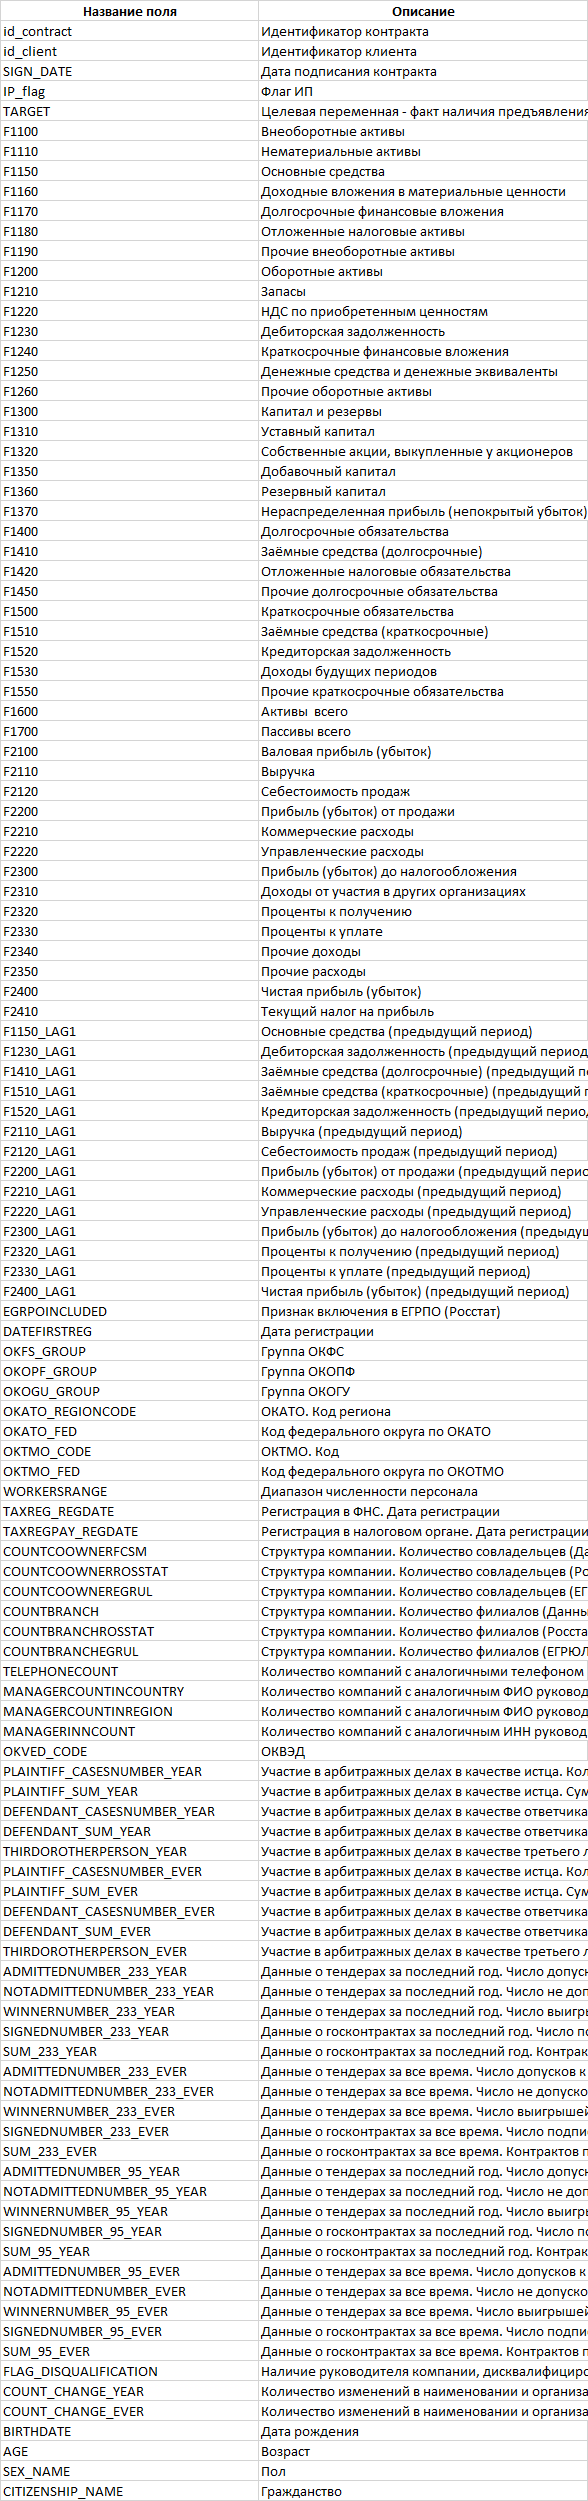

### Анализ и подготовка данных

#### Предобработка

**Приведение колонок к строчному виду**

In [6]:
train.columns = train.columns.str.lower()

**Удаление колонок с большим количеством пропусков**

При наличии больше половины пропусков, такой признак удаляется.

In [7]:
col = []
for name in train.columns:
  if train[train['target'] == 1][name].isna().mean() < 0.5:
    col.append(name)

train = train[col].copy()

In [8]:
train.shape

(17891, 47)

In [9]:
train.head()

,id_contract,id_client,sign_date,ip_flag,target,f1200,f1230,f1250,f1300,f1500,f1520,f1600,f1700,f2110,f2120,f2200,f2300,f2350,f2400,egrpoincluded,datefirstreg,okfs_group,okopf_group,okogu_group,okato_regioncode,okato_fed,oktmo_code,oktmo_fed,workersrange,taxreg_regdate,taxregpay_regdate,countcoownerfcsm,countcoownerrosstat,countcoowneregrul,countbranch,countbranchrosstat,countbranchegrul,telephonecount,managercountincountry,managercountinregion,managerinncount,okved_code,admittednumber_95_ever,notadmittednumber_ever,winnernumber_95_ever,signednumber_95_ever,sum_95_ever
0,1,1847,01JAN2018:00:00:00,0,0,1.048287e+10,9.477348e+09,3.312980e+08,1.960896e+09,9.480796e+09,6.907960e+09,1.178183e+10,1.178183e+10,5.294104e+10,5.057016e+10,631752000.0,8.834700e+07,1.479338e+09,3.908700e+07,1.0,10AUG1993:00:00:00,Частная собственность,Коммерческая корпоративная организация,Группировки хозяйствующих субъектов и обществе...,3.0,40.0,3.701000e+09,40.0,1001 .. 5000,01JUL2006:00:00:00,01JAN1960:00:00:00,5.0,1.0,0.0,8.0,7.0,7.0,3.0,0.0,0.0,0.0,35.14,NaN,NaN,NaN,NaN,NaN
1,2,4650,01JAN2018:00:00:00,1,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,4770,01JAN2018:00:00:00,0,0,2.161000e+07,1.764200e+07,5.530000e+05,9.073600e+07,4.248000e+06,4.171000e+06,9.498400e+07,9.498400e+07,5.218400e+07,4.286900e+07,2569000.0,1.190000e+06,1.494000e+06,6.550000e+05,1.0,04FEB1992:00:00:00,Государственная собственность,Коммерческая унитарная организация,Группировки хозяйствующих субъектов и обществе...,33.0,33.0,3.371000e+10,33.0,51 .. 100,30AUG2002:00:00:00,01JAN1960:00:00:00,0.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,36.00.2,169.0,0.0,169.0,168.0,18351739.0
3,4,12237,01JAN2018:00:00:00,0,0,5.786965e+09,1.232486e+09,4.459193e+09,2.685905e+09,4.411295e+09,3.092581e+09,7.724453e+09,7.724453e+09,4.028466e+10,2.334412e+10,931118000.0,1.489204e+09,1.335281e+09,1.102019e+09,1.0,01JUL2005:00:00:00,Частная собственность,Коммерческая корпоративная организация,Группировки хозяйствующих субъектов и обществе...,71.0,34.0,7.187600e+10,34.0,501 .. 1000,01JUL2005:00:00:00,01JAN1960:00:00:00,1.0,1.0,1.0,0.0,0.0,2.0,8.0,1.0,1.0,1.0,35.14,NaN,NaN,NaN,NaN,NaN
4,5,9988,01JAN2018:00:00:00,1,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


**Обработка даты**

In [10]:
train[['sign_date', 'datefirstreg', 'taxreg_regdate', 'taxregpay_regdate']]

,sign_date,datefirstreg,taxreg_regdate,taxregpay_regdate
0,01JAN2018:00:00:00,10AUG1993:00:00:00,01JUL2006:00:00:00,01JAN1960:00:00:00
1,01JAN2018:00:00:00,NaN,NaN,NaN
2,01JAN2018:00:00:00,04FEB1992:00:00:00,30AUG2002:00:00:00,01JAN1960:00:00:00
3,01JAN2018:00:00:00,01JUL2005:00:00:00,01JUL2005:00:00:00,01JAN1960:00:00:00
4,01JAN2018:00:00:00,NaN,NaN,NaN
...,...,...,...,...
17886,07APR2019:00:00:00,08MAY2007:00:00:00,08MAY2007:00:00:00,01JAN1960:00:00:00
17887,08APR2019:00:00:00,31JUL1997:00:00:00,20DEC2002:00:00:00,01JAN1960:00:00:00
17888,08APR2019:00:00:00,20OCT2016:00:00:00,20OCT2016:00:00:00,01JAN1960:00:00:00
17889,08APR2019:00:00:00,29AUG2017:00:00:00,29AUG2017:00:00:00,01JAN1960:00:00:00


In [11]:
# замена пропусков дат первой регистрации на даты подписания
train['datefirstreg'] = train['datefirstreg'].where(
    ~train['datefirstreg'].isna(), train['sign_date'])

# замена пропусков дат регистрации ФНС на даты подписания
train['taxreg_regdate'] = train['taxreg_regdate'].where(
    ~train['taxreg_regdate'].isna(), train['sign_date'])

In [12]:
train[['sign_date', 'datefirstreg', 'taxreg_regdate']].head()

,sign_date,datefirstreg,taxreg_regdate
0,01JAN2018:00:00:00,10AUG1993:00:00:00,01JUL2006:00:00:00
1,01JAN2018:00:00:00,01JAN2018:00:00:00,01JAN2018:00:00:00
2,01JAN2018:00:00:00,04FEB1992:00:00:00,30AUG2002:00:00:00
3,01JAN2018:00:00:00,01JUL2005:00:00:00,01JUL2005:00:00:00
4,01JAN2018:00:00:00,01JAN2018:00:00:00,01JAN2018:00:00:00


**Конвертация столбцов с датой в формат datetime**

In [13]:
#convert date to datetime

for i in range(train.shape[0]):
  train.loc[i, 'sign_date_dt'] = (str(train['sign_date'][i])[0:2]+'-'
  +str(train['sign_date'][i])[2:5]+'-'+str(train['sign_date'][i])[5:9])

  train.loc[i, 'datefirstreg_dt'] = (str(train['datefirstreg'][i])[0:2]+'-'
  +str(train['datefirstreg'][i])[2:5]+'-'+str(train['datefirstreg'][i])[5:9])

  train.loc[i, 'taxreg_regdate_dt'] = (str(train['taxreg_regdate'][i])[0:2]+'-'
  +str(train['taxreg_regdate'][i])[2:5]+'-'+str(train['taxreg_regdate'][i])[5:9])


train['sign_date_dt'] = pd.to_datetime(train['sign_date_dt'], format='%d-%b-%Y')
train['datefirstreg_dt'] = pd.to_datetime(train['datefirstreg_dt'], format='%d-%b-%Y')
train['taxreg_regdate_dt'] = pd.to_datetime(train['taxreg_regdate_dt'], format='%d-%b-%Y')

train = train.drop(['sign_date', 'taxregpay_regdate', 'datefirstreg', 'taxreg_regdate'], axis = 1)

#creating new date features like timedelta 

train['first_reg_months'] = (train['sign_date_dt']-train['datefirstreg_dt']).astype(
    'timedelta64[M]').astype('int64')

#train['total_reg_months'] = (train['sign_date_dt']-train['taxreg_regdate_dt']).astype(
#   'timedelta64[M]').astype('int64')

Параллельно создаем новый признак - время с первой регистрации. 

Была идея создать суммарное время с постановки в налоговом органе, но выяснилось, что эти значения коррелируют друг с другом на 99%, поэтому от второго признака отказался. 

In [14]:
train[['sign_date_dt',	'datefirstreg_dt',	'taxreg_regdate_dt',
       'first_reg_months']].head()

,sign_date_dt,datefirstreg_dt,taxreg_regdate_dt,first_reg_months
0,2018-01-01,1993-08-10,2006-07-01,292
1,2018-01-01,2018-01-01,2018-01-01,0
2,2018-01-01,1992-02-04,2002-08-30,310
3,2018-01-01,2005-07-01,2005-07-01,150
4,2018-01-01,2018-01-01,2018-01-01,0


**Удаление дат**

In [15]:
train = train.drop(['sign_date_dt', 'datefirstreg_dt', 'taxreg_regdate_dt'], axis = 1)

**Удаление дубликатов**

Для обнаружения дубликатов нам мешает колонка 'id_contract', т.к. она почти дублирует индекс ее можно убрать, а потом восстановить

In [16]:
train = train.drop('id_contract', axis = 1)
print(f'Количество дубликатов без колонки id_contract и времени: {train.duplicated().sum()}')

Количество дубликатов без колонки id_contract и времени: 5855


In [17]:
train = train.drop_duplicates()
print(train.shape)

(12036, 43)


In [18]:
train['id_contract'] = train.index + 1

#### Замена пропусков

**Замена пропусков**

In [19]:
train.head()

,id_client,ip_flag,target,f1200,f1230,f1250,f1300,f1500,f1520,f1600,f1700,f2110,f2120,f2200,f2300,f2350,f2400,egrpoincluded,okfs_group,okopf_group,okogu_group,okato_regioncode,okato_fed,oktmo_code,oktmo_fed,workersrange,countcoownerfcsm,countcoownerrosstat,countcoowneregrul,countbranch,countbranchrosstat,countbranchegrul,telephonecount,managercountincountry,managercountinregion,managerinncount,okved_code,admittednumber_95_ever,notadmittednumber_ever,winnernumber_95_ever,signednumber_95_ever,sum_95_ever,first_reg_months,id_contract
0,1847,0,0,1.048287e+10,9.477348e+09,3.312980e+08,1.960896e+09,9.480796e+09,6.907960e+09,1.178183e+10,1.178183e+10,5.294104e+10,5.057016e+10,631752000.0,8.834700e+07,1.479338e+09,3.908700e+07,1.0,Частная собственность,Коммерческая корпоративная организация,Группировки хозяйствующих субъектов и обществе...,3.0,40.0,3.701000e+09,40.0,1001 .. 5000,5.0,1.0,0.0,8.0,7.0,7.0,3.0,0.0,0.0,0.0,35.14,NaN,NaN,NaN,NaN,NaN,292,1
1,4650,1,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,2
2,4770,0,0,2.161000e+07,1.764200e+07,5.530000e+05,9.073600e+07,4.248000e+06,4.171000e+06,9.498400e+07,9.498400e+07,5.218400e+07,4.286900e+07,2569000.0,1.190000e+06,1.494000e+06,6.550000e+05,1.0,Государственная собственность,Коммерческая унитарная организация,Группировки хозяйствующих субъектов и обществе...,33.0,33.0,3.371000e+10,33.0,51 .. 100,0.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,36.00.2,169.0,0.0,169.0,168.0,18351739.0,310,3
3,12237,0,0,5.786965e+09,1.232486e+09,4.459193e+09,2.685905e+09,4.411295e+09,3.092581e+09,7.724453e+09,7.724453e+09,4.028466e+10,2.334412e+10,931118000.0,1.489204e+09,1.335281e+09,1.102019e+09,1.0,Частная собственность,Коммерческая корпоративная организация,Группировки хозяйствующих субъектов и обществе...,71.0,34.0,7.187600e+10,34.0,501 .. 1000,1.0,1.0,1.0,0.0,0.0,2.0,8.0,1.0,1.0,1.0,35.14,NaN,NaN,NaN,NaN,NaN,150,4
4,9988,1,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,5


In [20]:
train.columns

Index(['id_client', 'ip_flag', 'target', 'f1200', 'f1230', 'f1250', 'f1300',
       'f1500', 'f1520', 'f1600', 'f1700', 'f2110', 'f2120', 'f2200', 'f2300',
       'f2350', 'f2400', 'egrpoincluded', 'okfs_group', 'okopf_group',
       'okogu_group', 'okato_regioncode', 'okato_fed', 'oktmo_code',
       'oktmo_fed', 'workersrange', 'countcoownerfcsm', 'countcoownerrosstat',
       'countcoowneregrul', 'countbranch', 'countbranchrosstat',
       'countbranchegrul', 'telephonecount', 'managercountincountry',
       'managercountinregion', 'managerinncount', 'okved_code',
       'admittednumber_95_ever', 'notadmittednumber_ever',
       'winnernumber_95_ever', 'signednumber_95_ever', 'sum_95_ever',
       'first_reg_months', 'id_contract'],
      dtype='object')

In [21]:
train = train.drop (['oktmo_code', 'oktmo_fed', 'winnernumber_95_ever', 'signednumber_95_ever'], 1)

Надо написать функцию, чтобы ее можно было применить и к тестовой выборке, а не прописывать еще раз вручную

In [22]:
def replacer (table):

  f_columns = ['f1200', 'f1230', 'f1250', 'f1300',
       'f1500', 'f1520', 'f1600', 'f1700', 'f2110', 'f2120', 'f2200', 'f2300',
       'f2350', 'f2400']
  for col in f_columns:
    table[col] = table[col].fillna(table[col].median())
    

  table['egrpoincluded'] = table['egrpoincluded'].fillna(2)

  table['okfs_group'] = table['okfs_group'].fillna('No_data')
  table['okopf_group'] = table['okopf_group'].fillna('No_data')
  table['okogu_group'] = table['okogu_group'].fillna('No_data')

  table['okato_regioncode'] = table['okato_regioncode'].fillna(99)
  table['okato_fed'] = table['okato_fed'].fillna(table['okato_fed'].mean())

  #replacing strings in workersrange into first count in string
  table['workersrange'] = table['workersrange'].replace('5000 и более', '5000 .. 6000')
  first_num = [str(x).partition(' .. ')[2] for x in table['workersrange']]
  i = 0
  for string in table['workersrange']:
    table['workersrange'].iloc[i] = first_num[i]
    i +=1
  table['workersrange'] = table['workersrange'].replace('', 5)
  table['workersrange'] = table['workersrange'].astype('int')

  table['countcoownerfcsm'] = table['countcoownerfcsm'].fillna(0)
  table['countcoownerrosstat'] = table['countcoownerrosstat'].fillna(1)
  table['countcoowneregrul'] = table['countcoowneregrul'].fillna(1)
  table['countbranch'] = table['countbranch'].fillna(0)
  table['countbranchrosstat'] = table['countbranchrosstat'].fillna(0)
  table['countbranchegrul'] = table['countbranchegrul'].fillna(0)
  table['telephonecount'] = table['telephonecount'].fillna(1)
  table['managercountincountry'] = table['managercountincountry'].fillna(1)
  table['managercountinregion'] = table['managercountinregion'].fillna(2)
  table['managerinncount'] = table['managerinncount'].fillna(1)
  table['admittednumber_95_ever'] = table['admittednumber_95_ever'].fillna(
      table['admittednumber_95_ever'].median())
  table['sum_95_ever'] = table['sum_95_ever'].fillna(
      table['sum_95_ever'].median())

  table['okved_code'] = table['okved_code'].fillna('46.46')

  #replacing strings in okved_code into first count in string
  first_num_okved = [str(x).partition('.')[0] for x in table['okved_code']]
  j = 0
  for string in table['okved_code']:
    table['okved_code'].iloc[j] = first_num_okved[j]
    j +=1
  table['okved_code'] = table['okved_code'].astype('int')

  return (table)

In [23]:
train = replacer(train)

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


## Обучение модели

### Catboost

In [24]:
train.index = train['id_contract']
X_train = train.drop(['target', 'id_client', 'id_contract'], axis = 1)
y_train = train['target']


In [25]:
X_train, X_valid, y_train, y_valid = train_test_split(
    X_train, y_train, test_size=0.25, random_state=42)

In [26]:
cat_features = ['okfs_group', 'okopf_group', 'okogu_group']

In [27]:
cb_n = CatBoostClassifier(verbose=False, random_seed = 2021, eval_metric ='AUC', depth = 4)
cb_n.fit(X_train, y_train, eval_set=(X_valid,y_valid), cat_features = cat_features)


In [28]:
cb_n.best_score_

{'learn': {'Logloss': 0.2769576830498611},
 'validation': {'AUC': 0.8686583050222385, 'Logloss': 0.37740534915723434}}

In [29]:
features_importance = pd.DataFrame (data = cb_n.get_feature_importance(), index = X_train.columns, columns = ['range'])
print (features_importance.sort_values(by = 'range',ascending  = False))

                           range
okved_code              9.742125
workersrange            9.374225
first_reg_months        7.028775
okato_regioncode        5.596263
notadmittednumber_ever  5.344847
f1300                   4.476744
f2350                   4.292311
admittednumber_95_ever  4.124673
telephonecount          3.783821
okfs_group              3.745697
okato_fed               3.541648
f2200                   3.506776
f1250                   2.654157
f2120                   2.633751
f2300                   2.625475
f1230                   2.587212
f2110                   2.523933
f1500                   2.485525
sum_95_ever             2.424092
f1520                   2.344337
f2400                   2.188852
f1700                   1.796181
f1200                   1.565362
okopf_group             1.526893
managerinncount         1.240484
managercountinregion    1.138776
f1600                   1.033176
countcoownerrosstat     0.954057
managercountincountry   0.946618
egrpoinclu

Удаляю не влияющие на работу модели признаки

In [30]:
im_features = features_importance[features_importance['range'] > 2].index
print (im_features)

Index(['f1230', 'f1250', 'f1300', 'f1500', 'f1520', 'f2110', 'f2120', 'f2200',
       'f2300', 'f2350', 'f2400', 'okfs_group', 'okato_regioncode',
       'okato_fed', 'workersrange', 'telephonecount', 'okved_code',
       'admittednumber_95_ever', 'notadmittednumber_ever', 'sum_95_ever',
       'first_reg_months'],
      dtype='object')


In [31]:
cb_n = CatBoostClassifier(verbose=False, random_seed = 2021, eval_metric ='AUC')

X_train_1 = X_train[im_features].copy()

X_train_1, X_valid_1, y_train_1, y_valid_1 = train_test_split(
    X_train_1, y_train, test_size=0.25, random_state=42)

cb_n.fit(X_train_1, y_train_1, eval_set=(X_valid_1,y_valid_1), cat_features=['okfs_group'])
cb_n.best_score_

{'learn': {'Logloss': 0.18266522039641586},
 'validation': {'AUC': 0.8835997813759651, 'Logloss': 0.3567689445071839}}

ROC-AUC на кросс-валидации **0.8836**

## Подготовка тестовой выборки

In [32]:
test.columns = test.columns.str.lower()

In [33]:
# замена пропусков дат первой регистрации на даты подписания
test['datefirstreg'] = test['datefirstreg'].where(
    ~test['datefirstreg'].isna(), test['sign_date'])

# замена пропусков дат регистрации ФНС на даты подписания
test['taxreg_regdate'] = test['taxreg_regdate'].where(
    ~test['taxreg_regdate'].isna(), test['sign_date'])

#convert data columns to datetime

for i in range(test.shape[0]):
  test.loc[i, 'sign_date_dt'] = (str(test['sign_date'][i])[0:2]+'-'
  +str(test['sign_date'][i])[2:5]+'-'+str(test['sign_date'][i])[5:9])

  test.loc[i, 'datefirstreg_dt'] = (str(test['datefirstreg'][i])[0:2]+'-'
  +str(test['datefirstreg'][i])[2:5]+'-'+str(test['datefirstreg'][i])[5:9])

  test.loc[i, 'taxreg_regdate_dt'] = (str(test['taxreg_regdate'][i])[0:2]+'-'
  +str(test['taxreg_regdate'][i])[2:5]+'-'+str(test['taxreg_regdate'][i])[5:9])

test['sign_date_dt'] = pd.to_datetime(test['sign_date_dt'], format='%d-%b-%Y')
test['datefirstreg_dt'] = pd.to_datetime(test['datefirstreg_dt'], format='%d-%b-%Y')
test['taxreg_regdate_dt'] = pd.to_datetime(test['taxreg_regdate_dt'], format='%d-%b-%Y')

test = test.drop(['sign_date', 'taxregpay_regdate', 'datefirstreg', 'taxreg_regdate'], axis = 1)

#creating new date features like timedelta 

test['first_reg_months'] = (test['sign_date_dt']-test['datefirstreg_dt']).astype(
    'timedelta64[M]').astype('int64')

test['total_reg_months'] = (test['sign_date_dt']-test['taxreg_regdate_dt']).astype(
    'timedelta64[M]').astype('int64')

test = test.drop(['sign_date_dt', 'datefirstreg_dt', 'taxreg_regdate_dt'], axis = 1)

Замена пропусков функцией для обучающей выборки

In [34]:
test = replacer(test)

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


In [35]:
X_test = test[im_features].copy()
X_test.shape

(7330, 21)

Последний взгляд на данные перед загурзкой их в модель

In [36]:
X_test.head()

,f1230,f1250,f1300,f1500,f1520,f2110,f2120,f2200,f2300,f2350,f2400,okfs_group,okato_regioncode,okato_fed,workersrange,telephonecount,okved_code,admittednumber_95_ever,notadmittednumber_ever,sum_95_ever,first_reg_months
0,9074000.0,2034000.0,4370000.0,9383000.0,7400500.0,47897000.0,42366000.0,1649000.0,1659500.0,543000.0,1207000.0,No_data,99.0,33.718522,5,1.0,46,92.5,NaN,1.813208e+07,0
1,727000.0,9719000.0,15222000.0,1522000.0,1522000.0,310151000.0,307153000.0,2998000.0,2998000.0,543000.0,2398000.0,Частная собственность,24.0,30.000000,50,5.0,46,10240.0,69.0,1.187411e+09,109
2,56538000.0,8430000.0,4145000.0,91531000.0,91531000.0,506023000.0,457048000.0,1753000.0,1771000.0,708000.0,1400000.0,Частная собственность,75.0,34.000000,50,3.0,33,764.0,50.0,9.836260e+07,245
3,682000.0,920000.0,1038000.0,774000.0,774000.0,9793000.0,8731000.0,1062000.0,1027000.0,35000.0,933000.0,Частная собственность,40.0,31.000000,5,1.0,52,92.5,NaN,1.813208e+07,21
4,1410000.0,1000.0,1220000.0,1541000.0,1362000.0,6407000.0,6301000.0,106000.0,90000.0,23000.0,72000.0,Частная собственность,67.0,40.000000,5,1.0,43,92.5,NaN,1.813208e+07,53


In [37]:
test['TARGET'] = cb_n.predict_proba(X_test)[:, 1]
test[['id_contract', 'TARGET']].head()

,id_contract,TARGET
0,17892,0.062291
1,17893,0.010369
2,17894,0.017548
3,17895,0.132631
4,17896,0.564592


## Выгрузка результатов

In [38]:
test[['id_contract', 'TARGET']].to_csv('submit_file_88.csv', sep=';', index=False)

**Итоговая метрика - 0,8427**

Место 265 из 355.. Первый хакатон комом:)